In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import time
from tqdm import tqdm
from scipy import signal
from scipy.interpolate import interp1d
from IPython.display import Audio
from matplotlib.lines import Line2D

In [2]:
def raised_cosine_modified(N, beta):
    '''Creación de una ventana tipo pulso coseno elevado.
    
    Parameters
    ----------
    N : int
        Cantidad de puntos de la ventana.
    beta : float
        Parámetro de la función coseno elevado para la apertura de la ventana.
        
    Returns
    -------
    rc_out : ndarray
        Ventana pulso coseno elevado de N puntos con el valor de beta ingresado
    '''
    # Definición de la frecuencia f
    f = np.linspace(-1/2, 1/2, N)
    
    # Control de parámetro para beta
    if beta <= 0:
        beta = 0
    elif beta >= 1:
        beta = 1
    
    # Definición del vector de salida
    rc_out = np.array([])
    
    # Para punto f
    for i in f:
        if abs(i) <= (1 - beta)/2:
            rc_out = np.concatenate((rc_out, [1]))
        elif (1 - beta)/2 < abs(i) <= (1 + beta)/2:
            to_append =  np.cos(np.pi / beta * (abs(i) - (1 - beta)/2))
            rc_out = np.concatenate((rc_out, [to_append]))
        else:
            rc_out = np.concatenate((rc_out, [0]))
            
    return rc_out

In [3]:
def decimation_signal(signal_in, N_decimate):
    return signal_in[::N_decimate]


def stretch_signal(signal_in, N_stretch):
    return np.array([signal_in[i//N_stretch] if i%N_stretch == 0 else 0
                     for i in range(len(signal_in) * N_stretch)])


def beta_kaiser(A):
    '''Función por tramos que indica el valor que debe tomar el
    parámetro beta
    
    Parámetros
    - A: Ganancia máxima entre ripple de pasa banda y rechaza 
         banda obtenido anteriormente mediante la parametrización
         
    Referencias
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    '''
    if A < 21:
        return 0
    elif 21 <= A <= 50:
        return 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
    else:
        return 0.1102 * (A - 8.7)


def lowpass_filter(signal_in, samplerate, freq_pass, freq_stop,
                   method='fir', fir_method='kaiser', gpass=1, 
                   gstop=80, plot_filter=False, correct_by_gd=True,
                   gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuariom el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - samplerate: Tasa de muestreo de la señal utilizada
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - cutoff_freq: Frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - ['fir']: Se implementa mediante un filtro fir
        - ['iir']: Se implementa mediante un filtro iir
        - ['cut']: Se implementa simplemente cortando en la frecuencia de interés
    - fir_method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano que permite graficar la señal a ifiltrar y el filtro
    - correct_by_gd: Booleano que permite corregir la salida del filtro FIR por su
                     retraso de grupo
    - gd_padding: Formato para el padding de la señal de entrada
        - [None]: No se hace padding
        - ['zero']: Se hace padding con "len(signal_in)" ceros a la izquierda y
                    derecha de la señal
        - ['periodic']: Se hace padding copiando la señal 3 veces
        - ['constant']: Se hace padding copiando el primer y el último valor para
                        el caso de la izquierda y la derecha respectivamente
    - normalize: Normalización de la señal de salida
    '''
    # Obtención de los parámetros para cada método
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 print_window=plot_filter, apply_firwin=False)
        den = 1
        
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / samplerate,
                                    ws=freq_stop / samplerate,
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
    elif method == 'cut':
        gd = 0 
        signal_filtered =  lowpass_cut_frequency(signal_in, samplerate, 
                                                 freq_stop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
    
    # Presentación de la señal de entrada
    if gd_padding is None:
        signal_to_filt = signal_in
    elif gd_padding == 'zero':
        signal_to_filt = np.concatenate(([0] * len(signal_in),
                                         signal_in,
                                         [0] * len(signal_in)))
    elif gd_padding == 'periodic':
        signal_to_filt = np.concatenate((signal_in,
                                         signal_in,
                                         signal_in))
    elif gd_padding == 'constant':
        signal_to_filt = np.concatenate(([signal_in[0]] * len(signal_in),
                                         signal_in,
                                         [signal_in[-1]] * len(signal_in)))
    else:
        raise Exception('Opción de padding no disponible. Por favor, intente '
                        'nuevamente')
    
    # Para poder filtrar el audio
    if method != 'cut':
        _, gd = signal.group_delay((num, den))
        signal_filtered = signal.lfilter(num, den, signal_to_filt)
        
        # Si se hace padding, se debe cortar de tal forma que se logre sincro-
        # nizar la señal de entrada en función del delay de grupo
        if gd_padding is not None:
            # Delay de grupo aproximado
            delay = round(np.mean(gd))
            
            # Definición de los índices a considerar. Se escogen estos índices
            # ya que se asume que el comportamiento ideal de la señal 3 veces
            # paddeada, se encuentra en el centro del arreglo
            ini_index = int(len(signal_in) + delay)
            end_index = int(2 * len(signal_in) + delay)
            
            # Recortando
            signal_filtered = signal_filtered[ini_index:end_index]
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return gd, signal_filtered / max(abs(signal_filtered))
    else:
        return gd, signal_filtered


def lowpass_cut_frequency(signal_in, samplerate, freq_stop,
                          signal_ref=None):
    '''Función de filtro pasa bajos que corta en una frecuencia 
    determinada, simplemente haciendo cero las frecuencias más
    altas que la frecuencia de corte.
    
    Parámetros
    - signal_in: Señal de entrada
    - samplerate: Frecuencia de muestreo de la señal
    - freq_stop: Frecuencia de corte de la señal
    - signal_ref: Señal de referencia (se utiliza en caso de que 
                  se busque que la señal de salida sea de un largo
                  distinto al de la señal de entrada, por ejemplo,
                  en un proceso de upsampling)
    '''
    # Condición de inicio
    if signal_ref is None:
        signal_ref = signal_in
    
    # Frecuencia de corte relativa
    w_cut =  freq_stop / samplerate
    # Punto de la frecuencia de corte
    cutpoint = int(w_cut * len(signal_ref))

    # Calculando su transformada de Fourier
    signal_fft = np.fft.fft(signal_in)
    # Componentes de la FFT
    mag = np.abs(signal_fft)
    pha = np.angle(signal_fft)

    # Realización del corte en la frecuencia definida
    mag_cutted = np.concatenate((mag[:cutpoint], 
                                 [0] * (len(signal_in) - cutpoint * 2),
                                 mag[-cutpoint:]))

    # Reconstruyendo la señal
    signal_cutted = mag_cutted * np.exp(1j * pha)

    # Aplicando la trnasformada inversa
    signal_lp = np.real(np.fft.ifft(signal_cutted))
    
    return signal_lp


def fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=1,
                       gstop=50, use_exact=True, print_window=True,
                       method='window', parity='odd', 
                       apply_firwin=False):
    '''Diseño de filtros FIR mediante el método de ventaneo. Esta 
    función retorna los coeficientes h[n] del filtro en el tiempo.
    Este filtro minimiza el orden del filtro seleccionando la 
    ventana más conveniente en base a la declaración en decibeles
    de la ganancia de la rechaza banda.
    
    Parámetros
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - samplerate: Tasa de muestreo de la señal utilizada
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - use_exact: Booleano que indica si se usa el valor exacto de 
                 transición entre bandas (delta omega)
    - print_window: Booleano que indica si se imprime la ventana
                    seleccionada y su orden
    - method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    
    Referencias:
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    [2] Página CCRMA de Julius O. Smith III, disponible en:
        https://ccrma.stanford.edu/~jos/
    '''
    # Definición de los ripples en escala absoluta [1]
    delta_p = (10**(gpass/20) - 1)/(10**(gpass/20) + 1)
    delta_s = (1 + delta_p)/(10**(gstop/20))
    # Se escoge el mínimo delta para el diseño de la
    # ganancia A [1]
    delta = min(delta_p, delta_s)
    
    # Definición de ganancia límite
    A = -20*np.log10(delta) 
    
    # Definición de la frecuencia de corte
    cutoff_freq = (freq_pass + freq_stop) / 2
    # Definición de la frecuencia central angular
    omega_c = 2 * np.pi * cutoff_freq / samplerate
    
    # Definición del ancho de banda delta omega 
    trans_width = abs(freq_pass - freq_stop)
    # Definición del ancho de banda delta omega angular
    band_w = 2 * np.pi * trans_width / samplerate
    
    # Para el procedimiento del filtro FIR mediante ventaneo
    if method == 'window':
        # Definición de las ventanas
        windows = (('rectangular', 21, 4 * np.pi, 1.8 * np.pi),
                   ('bartlett', 26, 8 * np.pi, 6.1 * np.pi),
                   ('hann', 44, 8 * np.pi, 6.2 * np.pi),
                   ('hamming', 53, 8 * np.pi, 6.6 * np.pi),
                   ('blackman', 71, 12 * np.pi, 11 * np.pi))

        # Selección de la ventana
        index_window = np.argmin([abs(i[1] - A) for i in windows])

        # Definición de la ventana elegida
        window_choose = windows[index_window][0]
        
        # Una vez seleccionada la ventana, se escoge el orden del filtro,
        # procurando que el ancho del lóbulo principal no sea más grande
        # que la frecuencia de corte [1][2]
        delta_w = 3 if use_exact else 2
        L = round(windows[index_window][delta_w] / band_w)

        # Definición del orden del polinomio de la función de trans-
        # ferencia (largo del filtro). Mientras que L es el largo de
        # la respuesta al impulso
        M = L - 1
        
    # Para el procedimiento mediante ventana kaiser
    elif method == 'kaiser':
        # Definición de la ventana elegida
        window_choose = 'kaiser' 
        
        # Cálculo del beta
        beta = beta_kaiser(A)
        
        # Estimación del orden del filtro [1]
        M = int(np.ceil((A - 8) / (2.285 * band_w)))  
    # Para el procedimiento mediante algoritmo remez
    elif method == 'remez':
        # El orden del filtro está dado por la relación empírica 
        # propuesta por Kaiser
        M = (-20*np.log10(np.sqrt(delta_s*delta_p)) - 13)/(2.324*band_w)
        # Definición del parámetro de construcción de la ventana
        K = delta_p/delta_s
        
        # Especificación del filtro
        M = int(np.ceil(M))
        M = M  if M % 2 == 0 else M + 1
        
        # Se define el set de frecuencias crítico para el algotitmo
        # el cual contiene [0, wp, ws, pi], donde todas son divididas
        # en 2*pi (se expresan en "f").
        fo = [0, freq_pass, freq_stop, samplerate/2]
        
        
        # Este vector contiene los valores que tomarán las amplitudes de
        # las frecuencias de interés definidas anteriormente (cada una 
        # representa un rango, por ejemplo entre 0 y freq_pass -> 1  
        # y entre  freq_stop y samplerate/2 -> 0)
        ao = [1, 0]
        
        # Corresponde a los valores que toma la función W(omega) para 
        # cada banda
        W = [1, K]
        
        # Aplicando entonces Parks-McClellan
        return signal.remez(M + 1, fo, ao, W, fs=samplerate)
    
    # Si es que M es impar, mantenerlo impar, si es que es par, 
    # sumar 1
    M = M  if M % 2 == 0 else M + 1
    # Redefiniendo L
    L = M + 1
    
    if print_window:
        print(f'Ventana: {window_choose}\n'
              f'Largo resp. al impulso: {L}')
    
    # Aplicando el filtro
    if apply_firwin:
        if window_choose == 'kaiser':
            window_choose = ('kaiser', beta)
            
        return signal.firwin(L, cutoff_freq, 
                             window=window_choose,
                             fs=samplerate)
    else:
        # Selección de ventana
        if window_choose == 'rectangular':
            window = np.ones(L)
        elif window_choose == 'bartlett':
            window = np.bartlett(L)
        elif window_choose == 'hann':
            window = np.hanning(L)
        elif window_choose == 'hamming':
            window = np.hamming(L)
        elif window_choose == 'blackman':
            window = np.blackman(L)
        elif window_choose == 'kaiser':
            window = np.kaiser(L, beta)
        
        # Definición de la respuesta al impulso del filtro pasabajo 
        # ideal
        hd = lambda n: (np.sin(omega_c*(n - M/2))/(np.pi*(n - M/2)))\
                        if (n != M/2) else omega_c/np.pi
        
        # Calculando
        hd_n = np.asarray([hd(i) for i in range(L)])
        return  hd_n * window


def downsampling_signal(signal_in, samplerate, freq_pass, freq_stop, 
                        method='lowpass', lp_method='fir',
                        resample_method='interp1d',
                        fir_method='kaiser', gpass=1, gstop=80,
                        correct_by_gd=True, gd_padding='periodic',
                        plot_filter=False, normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir, dada una frecuencia de corte
    de interés, se resampleará la señal al doble de esa frecuencia.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda. Esta es la que se toma
        en cuenta al momento de hacer el último corte (por ende, si 
        busca samplear a 2kHz, seleccione este parámetro en 1kHz).
    method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    resample_method : {'resample', 'resample poly', 'interp1d', 'decimation'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'decimation' se  realiza una 
        decimación a la señal por un parámetro "N_dec" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    -----------
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula el paso de la decimación
    N_dec = round(samplerate / (freq_stop * 2))
    
    # Calculo de la nueva tasa de muestreo
    new_rate = 2 * freq_stop
    
    # Selección del método del pasabajos
    if method == 'lowpass':
        # Aplicando el filtro pasa bajos
        _, signal_lp = lowpass_filter(signal_in, samplerate, freq_pass, 
                                      freq_stop, method=lp_method, 
                                      fir_method=fir_method, gpass=gpass, 
                                      gstop=gstop, plot_filter=plot_filter,
                                      correct_by_gd=correct_by_gd,
                                      gd_padding=gd_padding,
                                      normalize=normalize)
    elif method == 'cut':
        signal_lp = lowpass_cut_frequency(signal_in, samplerate, 
                                          freq_stop)
    else:
        raise Exception('Opción de método no válido. Por favor, ingrese'
                        ' un valor válido.')
    
    # Selección del método de resampleo
    if resample_method == 'resample':
        return new_rate, signal.resample(signal_lp, 
                                         len(signal_lp)//N_dec)
    
    elif resample_method == 'resample_poly':
        return new_rate, signal.resample_poly(signal_lp, 
                                              len(signal_lp)//N_dec, 1)
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_lp))
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_lp) - 1, len(signal_lp)//N_dec)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_lp)

        return new_rate, f(x_new)
    
    elif resample_method == 'decimation':
        # Calculo de la nueva tasa de muestreo
        new_rate = samplerate // N_dec
        
        return new_rate, decimation_signal(signal_lp, N_decimate=N_dec)


def upsampling_signal(signal_in, samplerate, new_samplerate,
                      N_desired=None, method='lowpass',
                      trans_width=50, lp_method='fir',
                      resample_method='interp1d',
                      fir_method='kaiser', gpass=1, gstop=80, 
                      correct_by_gd=True, gd_padding='periodic',
                      plot_filter=False, plot_signals=False,
                      normalize=True):
    '''Función que permite aumentar la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la nueva tasa
    de muestreo deseada.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    new_samplerate : int
        Tasa de muestreo deseada de la señal.
    method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    trans_width : int 
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones [1]
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    resample_method : {'resample', 'resample poly', 'interp1d', 'stretching'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    plot_signals : bool
        Activar ploteo de la magnitud de las señales.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula la cantidad de puntos a añadir en stretch
    N_st = int(new_samplerate / samplerate)
    
    if resample_method == 'stretching':
        # Aplicando stretching
        signal_stretched = stretch_signal(signal_in, N_stretch=N_st)

        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            if len(signal_stretched) < N_desired: 
                signal_stretched = np.append(signal_stretched,
                                             [0] * (N_desired \
                                                    - len(signal_stretched)))
            else:
                signal_stretched = signal_stretched[:N_desired]


        if method == 'lowpass':
            # Definición de las bandas del filtro
            freq_stop = samplerate / 2
            freq_pass = freq_stop - trans_width

            # Aplicando el filtro
            _, signal_out = lowpass_filter(signal_stretched, new_samplerate, 
                                           freq_pass, freq_stop, method=lp_method, 
                                           fir_method=fir_method, gpass=gpass, 
                                           gstop=gstop, correct_by_gd=correct_by_gd,
                                           gd_padding=gd_padding,
                                           plot_filter=plot_filter, 
                                           normalize=normalize)    
        elif method == 'cut':
            # Definición de la frecuencia de corte
            freq_stop = samplerate / 2
            # Método de corte
            signal_out = lowpass_cut_frequency(signal_stretched, samplerate, 
                                               freq_stop, signal_ref=signal_in)
        
    elif resample_method == 'resample':
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / new_samplerate * samplerate)
        
        signal_out = signal.resample(signal_in, N_out)
    
    elif resample_method == 'resample_poly':
        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / new_samplerate * samplerate)
        
        # Señal resampleada
        signal_out = signal.resample_poly(signal_in, N_out, len(signal_in))
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_in))
        
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / new_samplerate * samplerate)
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_in) - 1, N_out)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_in)
        
        # Definición de la señal de salida
        signal_out = f(x_new)
    
    if plot_signals:
        plt.subplot(3,1,1)
        plt.plot(abs(np.fft.fft(signal_in)))
        plt.title('Magnitud señal de entrada')

        plt.subplot(3,1,2)
        plt.plot(abs(np.fft.fft(signal_stretched)))
        plt.title('Magnitud señal stretched')

        plt.subplot(3,1,3)
        plt.plot(abs(np.fft.fft(signal_out)))
        plt.title('Magnitud señal salida')

        plt.show()
    
    if normalize:
        return signal_out / max(abs(signal_out))
    else:
        return signal_out
    
    
def resampling_by_points(signal_in, samplerate, N_desired, trans_width=50,
                         resample_method='interp1d', lp_method='fir', fir_method='kaiser', 
                         gpass=1, gstop=80, correct_by_gd=True, gd_padding='periodic',
                         plot_filter=False, normalize=True):
    '''Función que resamplea una señal de entrada en función de la cantidad de puntos
    deseados de salida.
    
    Parameters
    ----------
    signal_in : list, tuple or ndarray
        Señal de entrada a resamplear.
    N_desired : int
        Cantidad de puntos deseada en la señal de salida.
    trans_width : int 
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones.
    resample_method : {'resample', 'resample poly', 'interp1d'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Returns
    -------
    signal_out : ndarray
        Señal resampleada con la cantidad de puntos solicitados en "N_desired".
    '''
    # En caso de que sea igual, se mantiene
    if N_desired == len(signal_in):
        # Solo se normaliza en caso de ser pertinente
        if normalize:
            return signal_in / max(abs(signal_in))
        else:    
            return signal_in
    
    # En caso de que sea menor, se aplica "downsampling" (resampleo)
    elif N_desired < len(signal_in):
        # Definición de la frecuencia de corte para aplicación en la función
        freq_stop = N_desired * samplerate / (2 * len(signal_in))
        # Definición de la frecuencia final de pasabanda
        freq_pass = freq_stop - trans_width
        
        # Aplicando el filtro pasa bajos (anti aliasing)
        _, signal_to_res = lowpass_filter(signal_in, samplerate, freq_pass, 
                                          freq_stop, method=lp_method, 
                                          fir_method=fir_method, 
                                          gpass=gpass, gstop=gstop, 
                                          plot_filter=plot_filter,
                                          correct_by_gd=correct_by_gd,
                                          gd_padding=gd_padding,
                                          normalize=normalize)
    
    # En caso de que sea mayor, se mantiene la señal normal
    elif N_desired > len(signal_in):
        # Solo se normaliza en caso de ser pertinente
        if normalize:
            signal_to_res = signal_in / max(abs(signal_in))
        else:    
            signal_to_res = signal_in
    
    # Y resampleando esta señal
    if resample_method == 'resample':
        # Señal de salida
        signal_out = signal.resample(signal_to_res, N_desired)

    elif resample_method == 'resample_poly':
        # Señal de salida
        signal_out = signal.resample_poly(signal_to_res, up=N_desired, 
                                          down=len(signal_in))

    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_to_res))

        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_in) - 1, N_desired)

        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_to_res)

        # Señal de salida
        signal_out = f(x_new)

    else:
        raise Exception('Opción no válida para el método. Por favor, '
                        'intente nuevamente con una opción válida.')
    
    return signal_out

In [8]:
def create_visual_lookups(N_periods, lens_sig, lens_sil):
    '''Función que permite crear una representación temporal de las activaciones
    de las señales de interés
    
    Parameters
    ----------
    N_periods : int
        Cantidad de perídos de activación que tendrá la señal.
    lens_sig : ndarray
        Arreglo de largos que tendrán las señales a replicar.
    lens_sil : ndarray
        Arreglo de largos que tendrán los silencios a replicar.
        
    Returns
    -------
    sawtooth_arr : ndarray
        Señal de diente de sierra de la activación de las señales.
    square_arr : ndarray
        Señal cuadrada de la activación de las señales.
    '''
    # Definición del arreglo donde se almacenará la forma del diente de sierra
    sawtooth_arr = np.array([])
    # Definición del arreglo donde se almacenará la forma de la señal cuadrada
    square_arr = np.array([])
    
    for i in range(N_periods):
        # Creación del vector de valores cero
        zeros_to_append = np.zeros(lens_sil[i])
        
        # Creación del vector de diente de sierra a revisar
        sawtooth_to_append = np.linspace(0, 1, lens_sig[i])
        
        # Creación del vector cuadrado a revisar
        square_to_append = np.ones(lens_sig[i])
        
        # Agregando los valores generados
        sawtooth_arr = np.concatenate((sawtooth_arr, zeros_to_append, 
                                       sawtooth_to_append))
        square_arr = np.concatenate((square_arr, zeros_to_append, 
                                     square_to_append))
    
    
    # Agregando los ceros finales del diente de sierra y cuadrado 
    # respectivamente
    sawtooth_arr = np.concatenate((sawtooth_arr, np.zeros(lens_sil[-1])))
    square_arr = np.concatenate((square_arr, np.zeros(lens_sil[-1])))
    
    return sawtooth_arr, square_arr


def create_signal_lookups(signals_in, N_periods, lens_sig, lens_sil, beta=0.2,
                          trans_width=50, resample_method='interp1d', lp_method='fir', 
                          fir_method='kaiser', gpass=1, gstop=80, 
                          correct_by_gd=True, gd_padding='periodic',
                          plot_filter=False, normalize=True):
    '''Función que permite crear una representación temporal de las activaciones
    de las señales de interés.
    
    Parameters
    ----------
    signals_in : list
        Lista de señales para la generación del sonido cardíaco. El primer elemento [0]
        contiene una lista de los sonidos S1. El segundo elemento [1] contiene una lista
        de los sonidos S2. Los sonidos, a su vez, contienen el audio y la tasa de muestreo.
    N_periods : int
        Cantidad de perídos de activación que tendrá la señal.
    lens_sig : ndarray
        Arreglo de largos que tendrán las señales a replicar.
    lens_sil : ndarray
        Arreglo de largos que tendrán los silencios a replicar.
    beta : float, optional
        Parámetro de la función coseno elevado utilizada para asegurar continuidad en los bordes
        de los sonidos cardíacos. Por defecto es 0.2.
    trans_width : int, optional
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones [1]. Por defecto es 50.
    resample_method : {'resample', 'resample poly', 'interp1d', 'stretching'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de entrada del
        filtro no es paddeada. Si se escoge "zero", se hace padding con "len(signal_in)" ceros a
        la izquierda y derecha de la señal. Si se escoge "periodic", se hace padding copiando la
        señal 3 veces. Si es "constant", se hace padding copiando el primer y el último valor
        para el caso de la izquierda y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool, optional
        Activar ploteo del filtro aplicado. Por defecto es False.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
        
    Returns
    -------
    signal_out : ndarray
        Señal con el sonido de interés repetido a intervalos dados por los 
        parámetros.
    '''
    # Definición del arreglo donde se almacenará la señal de salida
    signal_out = np.array([])
    
    # Definición del arreglo donde se almacenarán las etiquetas de cada
    # señal utilizada durante el proceso
    labels_out = list()
    
    for i in range(N_periods):
        # Creación del vector de valores cero
        zeros_to_append = np.zeros(lens_sil[i])
        
        # Sonidos pares son S1, e impares S2
        if i % 2 == 0:
            signal_set = signals_in[0]
        else:
            signal_set = signals_in[1]
            
        # Selección de la señal dentro del set
        signal_in, label = signal_set[np.random.randint(len(signal_set))]
        
        # Agregando la etiqueta a la lista de etiquetas para el registro
        labels_out.append(label)
        
        # Aplicando una ventana que permita eliminar los problemas de borde
        window = raised_cosine_modified(len(signal_in[0]), beta=beta)
        
        # Señal de entrada
        sig_in = signal_in[0] * window

        # Creación del vector de diente de sierra a revisar
        signal_to_append = resampling_by_points(signal_in=sig_in, 
                                                samplerate=signal_in[1], 
                                                N_desired=lens_sig[i], 
                                                trans_width=trans_width, 
                                                resample_method=resample_method, 
                                                lp_method=lp_method, 
                                                fir_method=fir_method, 
                                                gpass=gpass, gstop=gstop, 
                                                correct_by_gd=correct_by_gd, 
                                                gd_padding=gd_padding,
                                                plot_filter=plot_filter, 
                                                normalize=normalize)
        
        # Agregando los valores generados
        signal_out = np.concatenate((signal_out, zeros_to_append, 
                                     signal_to_append))

    # Agregando los ceros finales del diente de sierra y cuadrado 
    # respectivamente
    signal_out = np.concatenate((signal_out, np.zeros(lens_sil[-1])))
    
    return labels_out, signal_out


def lookup_table_function(signals_in, N_periods, params_signal, 
                          params_silence, beta=0.2, gen_type='normal', 
                          trans_width=50, resample_method='interp1d', lp_method='fir', 
                          fir_method='kaiser', gpass=1, gstop=80, 
                          correct_by_gd=True, gd_padding='periodic',
                          plot_filter=False, normalize=True):
    '''Función que permite crear un sonido cardíaco utilizando el método de lookup tables 
    (wave tables) a partir de un set de señales de entrada, creando también las señales de
    referencia que permitirán recorrer el wave table.
    
    Parameters
    ----------
    signals_in : list
        Lista de señales para la generación del sonido cardíaco. El primer elemento [0]
        contiene una lista de los sonidos S1. El segundo elemento [1] contiene una lista
        de los sonidos S2. Los sonidos, a su vez, contienen el audio y la tasa de muestreo.
    N_periods : int
        Cantidad de perídos de activación que tendrá la señal.
    params_signal : list or tuple, optional
        Parámetros que dependerán del formato de generación de números aleatorios elegido. Si es
        "normal", el índice 0 será mu y el 1 será sigma. Si es "uniforme", el índice 0 será el
        mínimo valor del largo posible y el índice 1 será el máximo valor del largo posible.
        Por defecto son: (5000,500).
    params_silence : list or tuple, optional
        Sigue la misma lógica que params_signal, pero aplicado a los intervalos en los que habrá
        silencio. Por defecto son: (15000,2000).
    beta : float, optional
        Parámetro de la función coseno elevado utilizada para asegurar continuidad en los bordes
        de los sonidos cardíacos. Por defecto es 0.2.
    gen_type : {'normal', 'uniform'}, optional
        Método de generación de números aleatorios. Al escoger "normal" se crearán mediante un
        proceso de generación vía dist. normal (0,1). Si se escoge "uniform", se crearán mediante
        un proceso de generación vía distribución uniforme. Por defecto es 'normal'.
    trans_width : int, optional
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones [1]. Por defecto es 50.
    resample_method : {'resample', 'resample poly', 'interp1d', 'stretching'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de entrada del
        filtro no es paddeada. Si se escoge "zero", se hace padding con "len(signal_in)" ceros a
        la izquierda y derecha de la señal. Si se escoge "periodic", se hace padding copiando la
        señal 3 veces. Si es "constant", se hace padding copiando el primer y el último valor
        para el caso de la izquierda y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool, optional
        Activar ploteo del filtro aplicado. Por defecto es False.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Returns
    -------
    tuple
        Donde los argumentos de salida son:
        1. Señal diente de sierra de referencia.
        2. Señal cuadrada de referencia.
        3. Una lista de los intervalos en los cuales se encuentran los sonidos cardíacos.
        4. Señal de sonido cardíaco generada.
    '''
    # Creación de los largos de cada intervalo
    if gen_type == 'normal':
        # Generación de números aleatorios
        rand_sig = np.random.randn(N_periods)
        rand_sil = np.random.randn(N_periods + 1)
        
        # Escalando y redoneando a la escala de interés
        lens_sig = np.rint(params_signal[1] * rand_sig + params_signal[0])
        lens_sil = np.rint(params_silence[1] * rand_sil + params_silence[0])
        
        # Pasando a valores enteros
        lens_sig = lens_sig.astype('int32')
        lens_sil = lens_sil.astype('int32')
        
    elif gen_type == 'uniform':
        # Generación de números aleatorios
        lens_sig = np.random.randint(low=params_signal[0],
                                     high=params_signal[1],
                                     size=N_periods)
        lens_sil = np.random.randint(low=params_silence[0],
                                     high=params_silence[1],
                                     size=N_periods + 1)
    else:
        raise Exception('Opción no válida para parámetro "gen_type". '
                        'Por favor, intente nuevamente con una opción'
                        ' válida.')
    
    # Definición de la lista para almacenar los intervalos de interés donde 
    # habrá sonido cardíaco
    intervals = list()
    
    for i in range(N_periods):
        # Intervalo donde el sonido se hace presente
        to_append = (sum(lens_sil[:i+1]) + sum(lens_sig[:i]), 
                     sum(lens_sil[:i+1]) + sum(lens_sig[:i+1]))
        intervals.append(to_append)
    
    # Creando las señales a rev
    sawtooth_arr, square_arr = create_visual_lookups(N_periods, lens_sig, lens_sil)
    
    # Creando la señal de interés
    signal_info = create_signal_lookups(signals_in, N_periods, lens_sig, lens_sil,
                                        beta=beta, trans_width=trans_width, 
                                        resample_method=resample_method,
                                        lp_method=lp_method, 
                                        fir_method=fir_method, 
                                        gpass=gpass, gstop=gstop, 
                                        correct_by_gd=correct_by_gd, 
                                        gd_padding=gd_padding,
                                        plot_filter=plot_filter, 
                                        normalize=normalize)
    
    return sawtooth_arr, square_arr, intervals, signal_info
    

def create_artificial_heart_sounds(filepath, N_periods, choose=1, seed=0, 
                                   beta=0.2, segments='Good_segments',
                                   params_signal=(5000,500), params_silence=(15000,2000),
                                   s1_selection=None, s2_selection=None, gen_type='normal',
                                   trans_width=50, resample_method='interp1d', lp_method='fir', 
                                   fir_method='kaiser', gpass=1, gstop=80, 
                                   correct_by_gd=True, gd_padding='periodic',
                                   plot_filter=False, plot_show=False,
                                   save_wav=True, normalize_res=False, 
                                   normalize_out=True):
    ''' Función que permite generar un archivo de audio de sonidos cardíacos y su plot 
    correspondientemente etiquetado (en base a los sonidos utilizados, ).
    
    Parameters
    ----------
    filepath : str
        Dirección donde se encuentra la carpeta madre de los archivos.
    N_periods : int
        Cantidad de perídos de activación que tendrá la señal.
    choose : int, optional
        Cantidad de señales base a elegir para el set de creación de sonidos cardíacos. Por
        defecto es 1.
    seed : int, optional
        Valor de la semilla a utilizar para el experimento. Por defecto es 0.
    beta : float, optional
        Parámetro de la función coseno elevado utilizada para asegurar continuidad en los bordes
        de los sonidos cardíacos. Por defecto es 0.2.
    segments : {'Good_segments', 'Heart_segments'}, optional
        Base de datos (carpeta) utilizada para generar los sonidos. Por defecto es 'Good_segments'.
    params_signal : list or tuple, optional
        Parámetros que dependerán del formato de generación de números aleatorios elegido. Si es
        "normal", el índice 0 será mu y el 1 será sigma. Si es "uniforme", el índice 0 será el
        mínimo valor del largo posible y el índice 1 será el máximo valor del largo posible.
        Por defecto son: (5000,500).
    params_silence : list or tuple, optional
        Sigue la misma lógica que params_signal, pero aplicado a los intervalos en los que habrá
        silencio. Por defecto son: (15000,2000).
    s1_selection : Nonetype or int, optional
        Sonido S1 seleccionado para la generación de sonido cardíaco. Por defecto es None.
    s2_selection : Nonetype or int, optional
        Sonido S2 seleccionado para la generación de sonido cardíaco. Por defecto es None.
    gen_type : {'normal', 'uniform'}, optional
        Método de generación de números aleatorios. Al escoger "normal" se crearán mediante un
        proceso de generación vía dist. normal (0,1). Si se escoge "uniform", se crearán mediante
        un proceso de generación vía distribución uniforme. Por defecto es 'normal'.
    trans_width : int, optional
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones [1]. Por defecto es 50.
    resample_method : {'resample', 'resample poly', 'interp1d', 'stretching'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de entrada del
        filtro no es paddeada. Si se escoge "zero", se hace padding con "len(signal_in)" ceros a
        la izquierda y derecha de la señal. Si se escoge "periodic", se hace padding copiando la
        señal 3 veces. Si es "constant", se hace padding copiando el primer y el último valor
        para el caso de la izquierda y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool, optional
        Activar ploteo del filtro aplicado. Por defecto es False.
    plot_show : bool, optional.
        Mostrar el plot. Por defecto es False.
    save_wav : bool, optional
        Grabar el archivo de audio. Por defecto es True.
    normalize_res : bool, optional
        Normalización de la lectura de las señales para generar (resample). Por defecto es False.
    normalize_out : bool, optional
        Normalización de la señal de sonido cardíaco para la salida. Por defecto es True.
    '''
    # Plantando la semilla
    np.random.seed(seed) 
    
    # Definición de lista de sonidos para usar
    s1_to_use = list()
    s2_to_use = list()
    
    # Definición de la carpeta a revisar para los archivos
    filepath_heart_sounds = f'{filepath}/{segments}' 
    
    if (s1_selection is not None) and (s2_selection is not None):
        # Largo de choose
        choose = 1
        
        # Lista con los nombres de los sonidos cardíacos
        heart_sounds = [i for i in os.listdir(filepath_heart_sounds) if i.endswith('.wav')]
        
        # Dado que en este caso se entregan los índices se obtiene el primer y segundo 
        # sonido cardíaco
        s1_choice = [i for i in heart_sounds if i.split('-')[0] == str(s1_selection)][0]
        s2_choice = [i for i in heart_sounds if i.split('-')[0] == str(s2_selection)][0]
        
        # Abriendo los sonidos correspondientes a la elección
        s1 = sf.read(f'{filepath_heart_sounds}/{s1_choice}')
        s2 = sf.read(f'{filepath_heart_sounds}/{s2_choice}')

        # Se agrega a la lista tanto el sonido como la etiqueta
        s1_to_use.append((s1, str(s1_selection)))
        s2_to_use.append((s2, str(s2_selection)))
        
        # Definición del nombre del archivo de salida
        filename = f'Seed[{seed}]_S1[{s1_selection}]_S2[{s2_selection}]'

        # Creación de la carpeta a almacenar la información
        filepath_to_save = f'{filepath}/Manual combinations'
    
    else:
        # Lista con los nombres de los sonidos cardíacos
        heart_sounds = [i for i in os.listdir(filepath_heart_sounds) if i.endswith('.wav')]

        # Separando en primer y segundo sonido cardíaco
        s1_sounds = [i for i in heart_sounds if "S1" in i]
        s2_sounds = [i for i in heart_sounds if "S2" in i]

        # Selección de sonidos a utilizar para crear la señal respiratoria
        s1_selection = np.random.randint(0, len(s1_sounds), size=choose)
        s2_selection = np.random.randint(0, len(s2_sounds), size=choose)

        # Definición de una lista de etiquetas
        s1_labels = list()
        s2_labels = list()
        
        for i in range(choose):
            # Sonido aleatorio elegido
            s1_choice = s1_sounds[s1_selection[i]]
            s2_choice = s2_sounds[s2_selection[i]]

            # Etiqueta de cada sonido
            s1_label = s1_choice.split('-')[0]
            s2_label = s2_choice.split('-')[0]

            # Abriendo los sonidos correspondientes a la elección
            s1 = sf.read(f'{filepath_heart_sounds}/{s1_choice}')
            s2 = sf.read(f'{filepath_heart_sounds}/{s2_choice}')

            # Se agrega a la lista tanto el sonido como la etiqueta
            s1_to_use.append((s1, s1_label))
            s2_to_use.append((s2, s2_label))
            
            # Agregando las etiquetas para el nombre
            s1_labels.append(s1_label)
            s2_labels.append(s2_label)
            
        # Definición del nombre del archivo de salida
        filename = f'Seed[{seed}]_S1{s1_labels}_S2{s2_labels}'

        # Creación de la carpeta a almacenar la información
        filepath_to_save = f'{filepath}/choose {choose}'
    
    # Creación de N_periods ciclos de S1-S2
    signals_in = (s1_to_use, s2_to_use)
        
    # Obteniendo las señales de salida
    sawtooth, square, intervals, signal_info =\
        lookup_table_function(signals_in, N_periods, 
                              params_signal=params_signal, 
                              params_silence=params_silence,
                              beta=beta,
                              gen_type=gen_type, 
                              trans_width=trans_width, 
                              resample_method=resample_method, 
                              lp_method=lp_method, 
                              fir_method=fir_method, 
                              gpass=gpass, gstop=gstop, 
                              correct_by_gd=correct_by_gd,
                              gd_padding=gd_padding, 
                              plot_filter=plot_filter, 
                              normalize=normalize_res)
    
    # Definición del nombre de salida del archivo, el cual estará codificado
    # como el "[# de la semilla]_S1[lista de S1]_S2[lista de S2].wav"
    s1_labels = str([i[1] for i in s1_to_use]).replace("'", "")
    s2_labels = str([i[1] for i in s2_to_use]).replace("'", "")
    
    # Nombre del archivo a guardar (por poner extensión)
    dir_to_save = f'{filepath_to_save}/{filename}'
    
    # Preguntar si es que la carpeta que almacenará las imágenes se ha
    # creado. En caso de que no exista, se crea una carpeta
    if not os.path.isdir(filepath_to_save):
        os.makedirs(filepath_to_save)
    
    plt.figure(figsize=(15,7))
    
    # Subplot de señales de referencia
    plt.subplot(2,1,1)
    plt.plot(square)
    plt.plot(sawtooth)
    plt.ylabel('Señales de\nreferencia')
    
    # Subplot de señal de salida
    plt.subplot(2,1,2)
    plt.plot(signal_info[1], linewidth=0.9)
    plt.xlabel('Muestras')
    plt.ylabel('Sonido\ncardíaco')
    
    for num, i in enumerate(intervals):
        # Definición de los colores utilizados para cada sonido cardíaco
        if num % 2 == 0:
            c_plot = 'r'
            c_span = 'orange'
        else:
            c_plot = 'limegreen'
            c_span = 'lime'
        
        # Rango en el que ploteará la señal
        x = np.arange(i[0], i[1])
        plt.plot(x, signal_info[1][x], c=c_plot)
        
        # Destacando toda la sección
        plt.axvspan(i[0], i[1], facecolor=c_span, alpha=0.3)
        
        # Añadiendo las etiquetas
        plt.text(i[0], min(signal_info[1]), signal_info[0][num], fontsize='small',
                    bbox=dict(boxstyle='circle', facecolor=c_span, alpha=0.2))
    
    # Creación de la leyenda
    plt.legend(handles=[Line2D([0], [0], color='r', lw=2, label='S1'),
                        Line2D([0], [0], color='limegreen', lw=2, label='S2')],
                loc='upper right')
    
    # Título del gráfico
    plt.suptitle(f'Sonido cardíaco: Semilla={seed}, N={N_periods}')
    
    # Mostrando
    if plot_show:
        plt.show()
    
    # Guardando
    plt.savefig(f'{dir_to_save}.png')
    
    # Opción de normalizar
    if normalize_out:
        signal_out = signal_info[1] / max(abs(signal_info[1]))
    else:
        signal_out = signal_info[1]
    
    # Opción de grabar sonido
    if save_wav:
        # Grabar el archivo .wav
        sf.write(f'{dir_to_save}.wav', signal_out, 44100)
    
    # Registrar los segmentos donde se encuentran los sonidos cardíacos
    with open(f'{dir_to_save} - segments.txt', 'w', encoding='utf8') as file:
        file.write(str(intervals))
    
    return signal_out


def get_heart_sounds_by_name(name, filepath, N_periods=30, seed=0, 
                             beta=0.2, segments='Good_segments'):
    ''' Rutina que permite generar archivos de sonido cardíaco utilizando los sonidos
    extraídos de pistas en particular. En este caso, no se mezclan distintas pistas de 
    la base de datos original.
    
    Parameters
    ----------
    name : str
        Nombre del archivo a partir del cual se obtienen los sonidos cardíacos
    filepath : str
        Dirección donde se encuentra la carpeta madre de los archivos.
    N_periods : int
        Cantidad de perídos de activación que tendrá la señal.
    seed : int, optional
        Valor de la semilla a utilizar para el experimento. Por defecto es 0.
    beta : float, optional
        Parámetro de la función coseno elevado utilizada para asegurar continuidad en los bordes
        de los sonidos cardíacos. Por defecto es 0.2.
    segments : {'Good_segments', 'Heart_segments'}, optional
        Base de datos (carpeta) utilizada para generar los sonidos. Por defecto es 'Good_segments'.
    '''
    # Plantando esta semilla para la generación de valores aleatorios
    np.random.seed(seed)
    
    # Definición de la carpeta a revisar para los archivos
    filepath_heart_sounds = f'{filepath}/{segments}' 
    
    # Archivos a trabajar
    heart_sounds = [i for i in os.listdir(filepath_heart_sounds) 
                    if i.endswith('.wav') and name in i]
    
    # Archivos para S1 y S2
    s1_indexes = [int(i.split('-')[0]) for i in heart_sounds if "S1" in i]
    s2_indexes = [int(i.split('-')[0]) for i in heart_sounds if "S2" in i]
    
    # Se obtienen todas las posibles combinaciones
    combinations = list(product(s1_indexes, s2_indexes))

    # Entonces para cada combinación se obtiene el sonido deseado
    for comb in combinations:
        seed_gen = np.random.randint(2**16)
        print(f'Generating files of S1 = {comb[0]} and S2 = {comb[1]} with seed {seed_gen}...')
        _ = \
            create_artificial_heart_sounds(filepath, N_periods=N_periods, 
                                           choose=1, seed=seed_gen, 
                                           beta=beta, segments=segments,
                                           params_signal=(5000,500), 
                                           params_silence=(15000,2000),
                                           s1_selection=comb[0], s2_selection=comb[1], 
                                           gen_type='normal',
                                           trans_width=50, resample_method='interp1d', 
                                           lp_method='fir', fir_method='kaiser', 
                                           gpass=1, gstop=80, correct_by_gd=True,
                                           gd_padding='periodic', plot_filter=False,
                                           plot_show=False, save_wav=True, 
                                           normalize_res=False, normalize_out=True)
        print('Completed!\n')


def get_heart_respiratory_sounds(dir_to_heart, a_heart=1, a_resp=1, a_noise=0, seed=0):
    '''Rutina que permite crear los sonidos cardíacos + respiratorios en una carpeta, tomando como
    base los archivos disponibles en "dir_to_heart" y "db_respiratory/Original".
    
    Parameters
    ----------
    dir_to_heart : str
        Dirección de los sonidos cardíacos a utilizar
    a_heart : float, optional
        Ponderación del sonido cardíaco en la mezcla. Por defecto es 1.
    a_resp : float, optional
        Ponderación del sonido respiratorio en la mezcla. Por defecto es 1.
    a_noise : float, optional
        Ponderación de un ruido blanco en la mezcla. Por defecto es 0.
    seed : int
        Semilla a utilizar para la creación del ruido blanco
    '''
    # Plantando esta semilla para la generación de valores aleatorios del ruido blanco
    np.random.seed(seed)
       
    # Definición del directorio donde se guardará
    folder_save = f'db_HR/'\
                  f'Seed-{seed} - {a_heart}_Heart {a_resp}_Resp {a_noise}_White noise'
    
    # Preguntar si es que la carpeta que almacenará los sonidos se ha
    # creado. En caso de que no exista, se crea una carpeta
    if not os.path.isdir(folder_save):
        os.makedirs(folder_save)
    
    # Definición del directorio a revisar para sonidos respiratorios
    dir_to_resp = 'db_respiratory/Original'
    # Definición del directorio a guardar para sonidos respiratorios cortados
    dir_to_resp_adapted = 'db_respiratory/Adapted'
    
    # Lista de sonidos cardiacos
    heart_sounds = [i for i in os.listdir(dir_to_heart) if i.endswith('.wav')]
    
    # Lista de sonidos respiratorios
    resp_sounds = [i for i in os.listdir(dir_to_resp) if i.endswith('.wav')] 

    # Definición de las posibles combinaciones entre sonidos
    combinations = tuple(product(resp_sounds, heart_sounds))
    
    for comb in tqdm(combinations, desc='Sounds', ncols=60):
        #print(f'Recording {comb[0]} + {comb[1]} sound...')
        # Abriendo los archivos de audio
        resp_audio, _ = sf.read(f'{dir_to_resp}/{comb[0]}')
        heart_audio, _ = sf.read(f'{dir_to_heart}/{comb[1]}')
        
        # Definición del largo máximo
        if len(resp_audio) < len(heart_audio):
            length = len(resp_audio)
        else:
            length = len(heart_audio)
        
        # Cortando el audio más largo hasta el largo del mínimo
        heart_to_sum = heart_audio[:length]
        resp_to_sum = resp_audio[:length]
        
        # Creación del ruido blanco
        white_noise = np.random.normal(0, 1, length)
        # Normalizando este sonido
        white_noise = white_noise / max(abs(white_noise))

        # Sonido cardíaco + respiratorio + ruido
        hr_sound = a_resp * resp_to_sum + a_heart * heart_to_sum + a_noise * white_noise
        
        # Definición del nombre de los archivos
        hr_filename = f'HR {comb[0][:-4]} {comb[1][:-4]}'
        
        # Dirección donde se guardará el archivo de audio
        dir_to_save = f'{folder_save}/{hr_filename}.wav'
        
        # Grabando el archivo de sonido cardíaco + respiratorio
        sf.write(dir_to_save, hr_sound, samplerate=44100)
        
        # Y grabando el sonido modificado del sonido respiratorio
        sf.write(f'{dir_to_resp_adapted}/{comb[0]}', resp_to_sum, samplerate=44100)

<IPython.core.display.Javascript object>


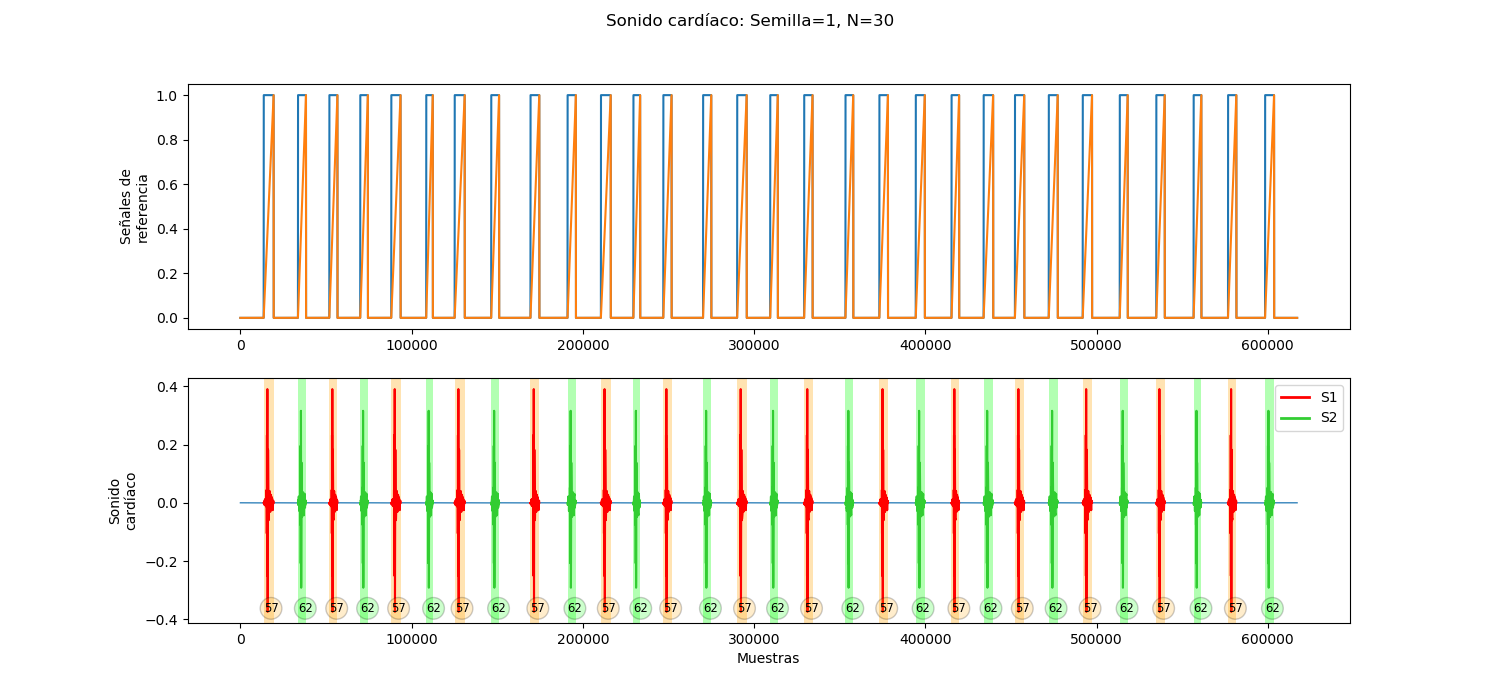

In [9]:
filepath = 'db_heart'

%matplotlib notebook
signal_out = create_artificial_heart_sounds(filepath, N_periods=30, seed=1, beta=0.2,
                                            s1_selection=59, s2_selection=60, plot_show=True)

Audio(signal_out, rate=44100)

# Probando la función de resampling

<IPython.core.display.Javascript object>


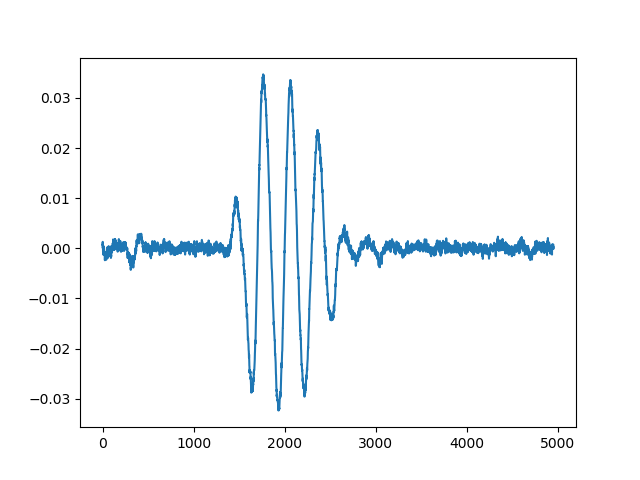

In [198]:
filename = '2-S2-normal__201101070538'
audio, samplerate = sf.read(f'db_heart/Heart_segments/{filename}.wav')
Audio(audio, rate=samplerate)

%matplotlib notebook
plt.plot(audio)
plt.show()

# Probar nuevo downsampling y upsampling

In [149]:
filename = '2-S2-normal__201101070538'
audio, samplerate = sf.read(f'db_heart/Heart_segments/{filename}.wav')

norm_audio = audio/max(abs(audio))